**📘 Week 2: Introduction to Constraints in Portfolio Optimization**

In this week, I studied why constraints are crucial for building practical, real-world portfolios. Here’s what I’ve learned:

---

### 🔒 Why Short Selling is Often Restricted

- 📉 **Unlimited Losses:** If a stock’s price rises instead of falling, losses can become infinite.
- 💰 **Margin Requirements:** Shorting needs collateral and higher capital requirements.
- ❗ **Negative Weights:** In portfolio optimization, short selling introduces negative weights — not always allowed or realistic.

---

### 📐 Common Constraints in Portfolios

- 💵 **Budget Constraint:** Total weights must sum to 1 — you can’t invest more money than you have.
- 📊 **Max Weight Limits:** To avoid over-concentration, we may restrict a single stock to, say, 30%.
- ⏳ **Risk Matching:** Choose lower risk if the investment horizon is short.
- 💧 **Liquidity Constraints:** Avoid stocks that can’t be sold easily during market stress.

---

### ⚠️ Why Naive Optimization Fails in Practice

- 🎯 May allocate too much to one high-return stock, reducing diversification.
- 🤖 Overfits to historical data — small input errors in returns/covariances can produce unstable portfolios.
- 🧪 Not robust to real-world trading limitations (like tax, liquidity, or regulation).

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

expected_returns = pd.read_csv("../Reports/expected_returns.csv",index_col= 0)
tickers = np.array(expected_returns.index)
cov_matrix = pd.read_csv("../Reports/cov_matrix.csv", index_col= 0)
risk_free_rate = 0.06
print(expected_returns,"\n",cov_matrix)

              Mean Annual Return
HDFCBANK.NS             0.163487
ICICIBANK.NS            0.322150
INFY.NS                 0.214204
RELIANCE.NS             0.171169
TCS.NS                  0.144119 
               HDFCBANK.NS  ICICIBANK.NS   INFY.NS  RELIANCE.NS    TCS.NS
HDFCBANK.NS      0.053002      0.031751  0.014150     0.019204  0.010385
ICICIBANK.NS     0.031751      0.063661  0.015485     0.019841  0.009939
INFY.NS          0.014150      0.015485  0.063522     0.015261  0.037833
RELIANCE.NS      0.019204      0.019841  0.015261     0.060963  0.014690
TCS.NS           0.010385      0.009939  0.037833     0.014690  0.047503


In [4]:
import numpy as np
from scipy.optimize import minimize

# Define functions
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    port_return = portfolio_return(weights, expected_returns)
    port_vol = portfolio_volatility(weights, cov_matrix)
    return -(port_return - risk_free_rate) / port_vol

# Data setup
expected_returns = expected_returns.values.flatten()  # Ensure it's 1D
cov_matrix = cov_matrix.values
risk_free_rate = 0.06
num_assets = len(expected_returns)

# Constraints: weights must sum to 1
constraints = ({
    'type': 'eq',
    'fun': lambda weights: np.sum(weights) - 1
})

# Bounds: No short-selling (0 to 1)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: Equal weights
init_guess = np.ones(num_assets) / num_assets

# Optimization
result = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(expected_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract optimal weights
optimal_weights = result.x
print(optimal_weights)


[0.00000000e+00 6.80755298e-01 2.71510082e-01 4.77346201e-02
 2.24925423e-18]


In [5]:
Max_sharpe_data = {
    "Returns" : portfolio_return(optimal_weights,expected_returns),
    "Volatility" : portfolio_volatility(optimal_weights,cov_matrix),
    "Sharpe Ratio" : -result.fun,
    "Weights" : optimal_weights
}
Max_sharpe_data

{'Returns': np.float64(0.28563429128024387),
 'Volatility': np.float64(0.20428673199536287),
 'Sharpe Ratio': np.float64(1.1044980213661921),
 'Weights': array([0.00000000e+00, 6.80755298e-01, 2.71510082e-01, 4.77346201e-02,
        2.24925423e-18])}

In [6]:

opt_weights_df = pd.DataFrame({
    "Stock": tickers,
    "Optimized Weights (Max Sharpe)": optimal_weights
})
opt_weights_df.set_index("Stock", inplace=True)
print(opt_weights_df)

              Optimized Weights (Max Sharpe)
Stock                                       
HDFCBANK.NS                     0.000000e+00
ICICIBANK.NS                    6.807553e-01
INFY.NS                         2.715101e-01
RELIANCE.NS                     4.773462e-02
TCS.NS                          2.249254e-18


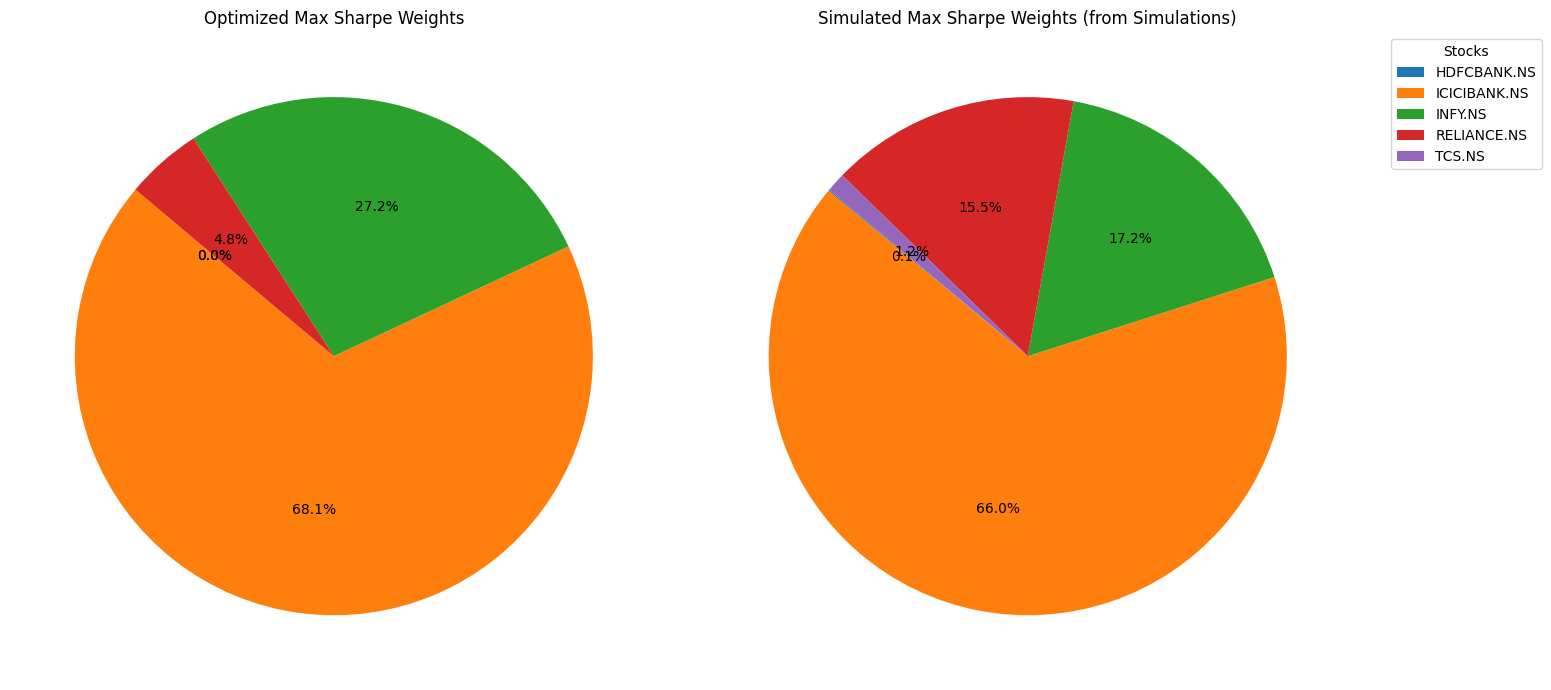

In [7]:
import matplotlib.pyplot as plt

opt_weights = optimal_weights 

# Read simulated weights (from optimal_portfolios.csv)
sim_df = pd.read_csv("../Reports/optimal_portfolios.csv", index_col=0)
sim_tickers = tickers
sim_weights = sim_df["Max Sharpe Weight"].values

# Pie chart for Optimized Max Sharpe Weights
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
patches1, texts1, autotexts1 = plt.pie(opt_weights, labels=None, autopct='%1.1f%%', startangle=140)
plt.title("Optimized Max Sharpe Weights")
# plt.legend(opt_tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

# Pie chart for Simulated Max Sharpe Weights
plt.subplot(1, 2, 2)
patches2, texts2, autotexts2 = plt.pie(sim_weights, labels=None, autopct='%1.1f%%', startangle=140,)
plt.title("Simulated Max Sharpe Weights (from Simulations)")
plt.legend(sim_tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("../Reports/Charts/max_sharpe_vs_simulated.png", dpi=300)
plt.show()

In [8]:
min_volatility_result = minimize(
    portfolio_volatility,
    x0=init_guess,
    args=(cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
# Create dictionary for Min Volatility portfolio
min_volatility_weights = min_volatility_result.x
min_volatility_data = {
    "Returns": portfolio_return(min_volatility_weights, expected_returns),
    "Volatility": portfolio_volatility(min_volatility_weights, cov_matrix),
    "Sharpe Ratio":-neg_sharpe_ratio(min_volatility_weights,expected_returns,cov_matrix,risk_free_rate),
    "Weights": min_volatility_weights
}

print(min_volatility_data)


{'Returns': np.float64(0.18609845913699502), 'Volatility': np.float64(0.16055070778207892), 'Sharpe Ratio': np.float64(0.7854120413355814), 'Weights': array([0.23711064, 0.1563626 , 0.06004688, 0.19745994, 0.34901993])}


In [9]:
# DataFrame for min volatility
min_vol_weights_df = pd.DataFrame({
    "Stock": tickers,
    "Optimized Weights (Min Volatility)": min_volatility_weights
})
min_vol_weights_df.set_index("Stock", inplace=True)
print(min_vol_weights_df)


              Optimized Weights (Min Volatility)
Stock                                           
HDFCBANK.NS                             0.237111
ICICIBANK.NS                            0.156363
INFY.NS                                 0.060047
RELIANCE.NS                             0.197460
TCS.NS                                  0.349020


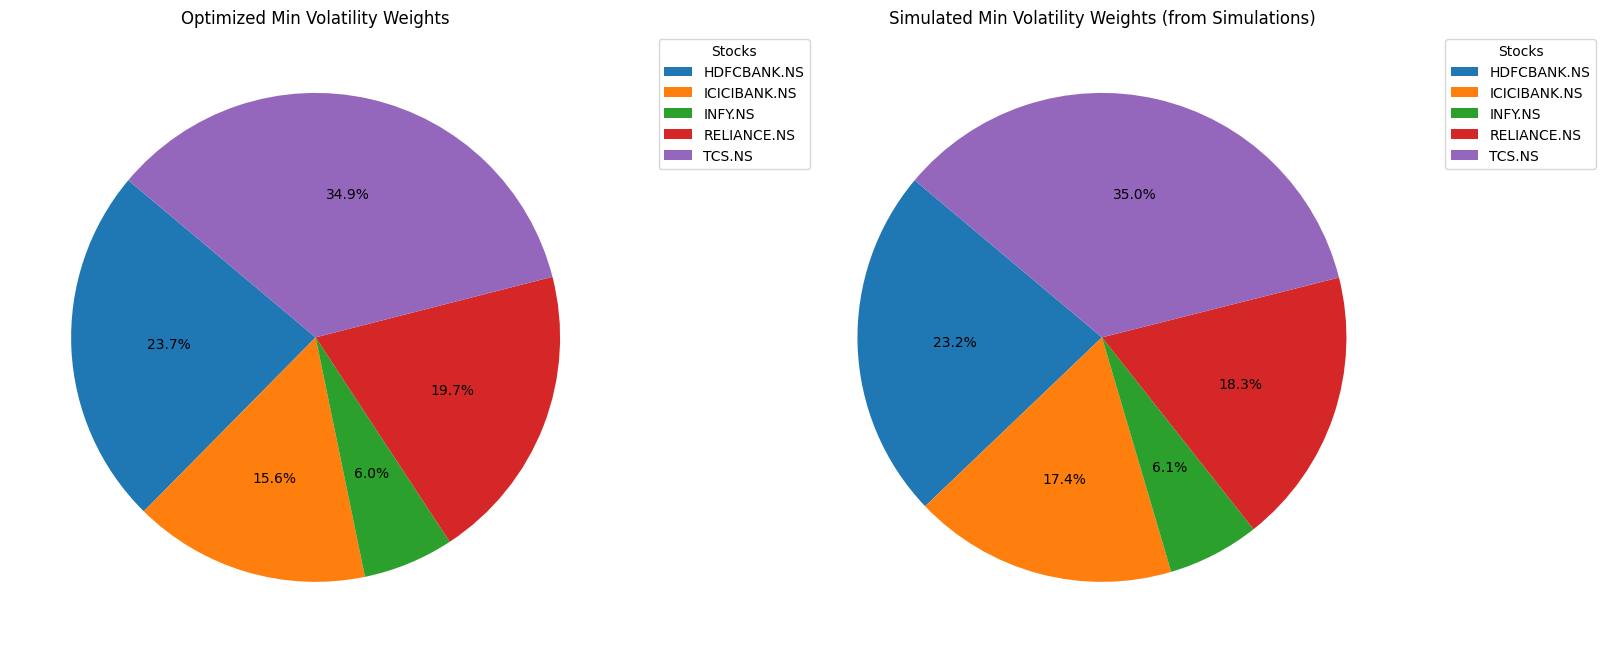

In [10]:
# Simulated min volatility weights from optimal_portfolios.csv
sim_min_vol_weights = sim_df["Min Volatility Weight"].values

# Pie chart comparison
plt.figure(figsize=(16, 7))

# Optimized Min Volatility
plt.subplot(1, 2, 1)
plt.pie(min_volatility_weights, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Optimized Min Volatility Weights")
plt.legend(tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

# Simulated Min Volatility
plt.subplot(1, 2, 2)
plt.pie(sim_min_vol_weights, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Simulated Min Volatility Weights (from Simulations)")
plt.legend(sim_tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("../Reports/Charts/min_volatility_vs_simulated.png", dpi=300)
plt.show()

## 📘 Day 8 Wrap-Up: Optimization with Constraints

### 🔍 What I Learned:
- I applied mathematical optimization to build portfolios under realistic constraints.
- I used `scipy.optimize.minimize()` to calculate the most efficient portfolios.
- I saw how constraints like "no short selling" and "weights must sum to 1" shape real-world portfolios.

### 🛠️ Optimization Outcomes:
- **Max Sharpe Portfolio** focused heavily on ICICIBANK.NS and INFY.NS, prioritizing return over risk.
- **Min Volatility Portfolio** had a more balanced allocation, leaning toward stable stocks like TCS.NS and HDFCBANK.NS.
- Both portfolios aligned closely with their simulated counterparts.

### 💭 Personal Observation:
Based on the constrained optimization results, the Minimum Volatility portfolio appears to be the most balanced and diversified. In contrast, the Maximum Sharpe Ratio portfolio is highly concentrated in a single stock, which increases the risk despite promising higher returns. To improve diversification and reduce over-reliance on one asset, additional constraints — such as setting a cap on individual stock weights — could be introduced in future optimizations.



In [23]:
bounds = tuple((0.05,0.3) for _ in range(num_assets))

opt_max_sharpe = minimize(
    neg_sharpe_ratio,
    x0=init_guess,
    args=(expected_returns,cov_matrix,risk_free_rate),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)

opt_max_sharpe_data = {
    'Returns' : portfolio_return(opt_max_sharpe.x,expected_returns),
    'Volatility' : portfolio_volatility(opt_max_sharpe.x , cov_matrix),
    'Sharpe Ratio' : -opt_max_sharpe.fun,
    'Weights' : opt_max_sharpe.x
}
print(opt_max_sharpe_data)

opt_max_sharpe_df = pd.DataFrame({
    "Stocks" : tickers,
    "Weights" : opt_max_sharpe_data['Weights']
})

opt_max_sharpe_df.set_index("Stocks",inplace= True)
opt_max_sharpe_df


opt_max_sharpe.fun

{'Returns': np.float64(0.22661545808751504), 'Volatility': np.float64(0.17100538784330355), 'Sharpe Ratio': np.float64(0.9743287050124344), 'Weights': array([0.12741636, 0.3       , 0.3       , 0.20679917, 0.06578447])}


np.float64(-0.9743287050124344)

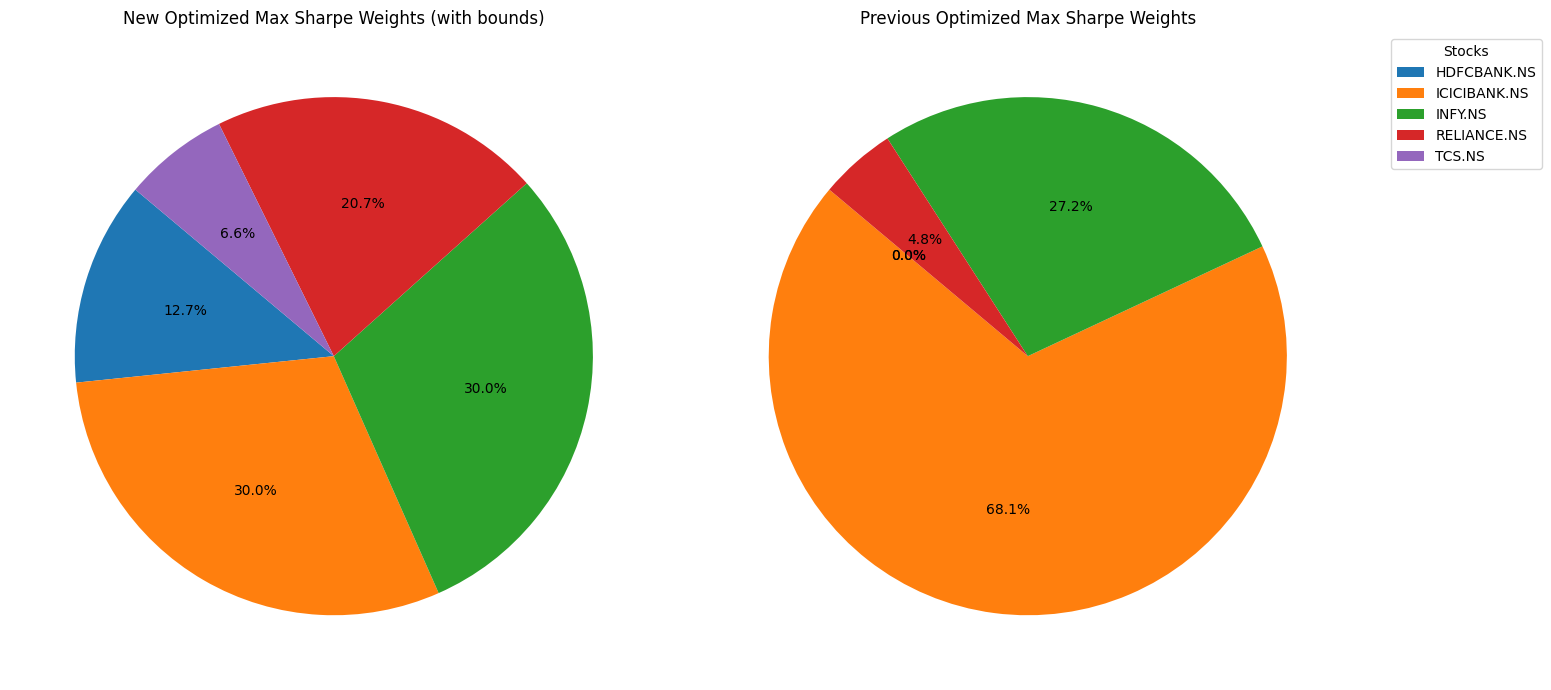

In [12]:
new_opt_weights = opt_max_sharpe_df["Weights"].values

prev_opt_weights = opt_weights_df["Optimized Weights (Max Sharpe)"].values

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.pie(new_opt_weights, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("New Optimized Max Sharpe Weights (with bounds)")

plt.subplot(1, 2, 2)
plt.pie(prev_opt_weights, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Previous Optimized Max Sharpe Weights")
plt.legend(tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("../Reports/Charts/max_sharpe_optimized_comparison.png", dpi=300)
plt.show()

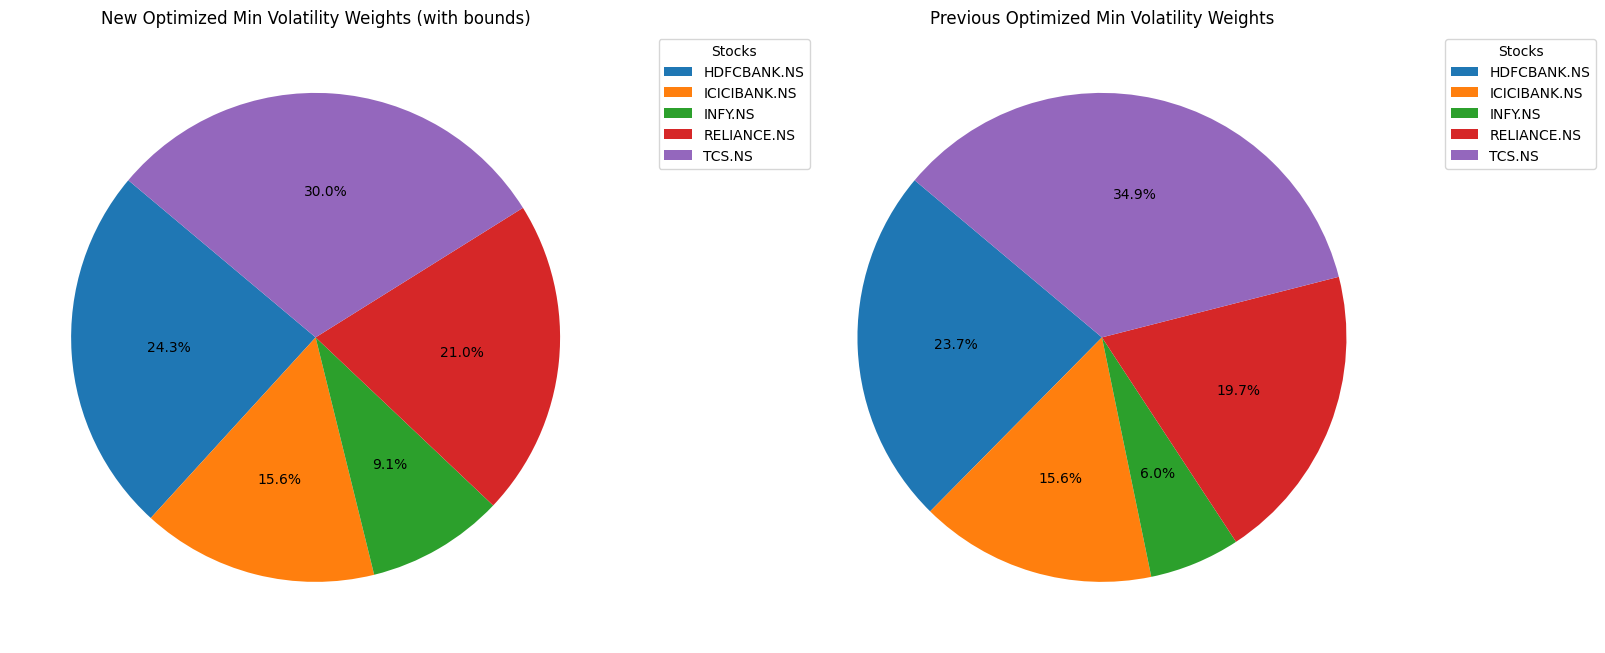

In [13]:
bounds = tuple((0.05, 0.3) for _ in range(num_assets))
opt_min_vol = minimize(
    portfolio_volatility,
    x0=init_guess,
    args=(cov_matrix,),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)

opt_min_vol_data = {
    'Returns': portfolio_return(opt_min_vol.x, expected_returns),
    'Volatility': portfolio_volatility(opt_min_vol.x, cov_matrix),
    'Sharpe Ratio': (portfolio_return(opt_min_vol.x, expected_returns) - risk_free_rate) / portfolio_volatility(opt_min_vol.x, cov_matrix),
    'Weights': opt_min_vol.x
}

opt_min_vol_df = pd.DataFrame({
    "Stocks": tickers,
    "Weights": opt_min_vol_data['Weights']
})
opt_min_vol_df.set_index("Stocks", inplace=True)
prev_min_vol_weights = min_vol_weights_df["Optimized Weights (Min Volatility)"].values

plt.figure(figsize=(16, 7))

# Pie chart for New Optimized Min Volatility Weights (with bounds)
plt.subplot(1, 2, 1)
plt.pie(opt_min_vol_df["Weights"].values, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("New Optimized Min Volatility Weights (with bounds)")
plt.legend(opt_min_vol_df.index.tolist(), title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

# Pie chart for Previous Optimized Min Volatility Weights
plt.subplot(1, 2, 2)
plt.pie(prev_min_vol_weights, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Previous Optimized Min Volatility Weights")
plt.legend(min_vol_weights_df.index.tolist(), title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("../Reports/Charts/min_volatility_optimized_comparison.png", dpi=300)
plt.show()

In [14]:
Weight_optimized_df = pd.DataFrame({
    "Stocks": tickers,
    "Max Sharpe Weights": opt_max_sharpe_data['Weights'],
    "Min Volatility Weights": opt_min_vol_data['Weights']
})

Weight_optimized_df.set_index('Stocks', inplace=True)
Weight_optimized_df.to_csv("../Reports/weight_optimized_portfolio.csv")

In [15]:
# Combine previous and new optimized weights for both Max Sharpe and Min Volatility into a DataFrame

# Max Sharpe
max_sharpe_combined_df = pd.DataFrame({
    "Previous Optimized Max Sharpe": prev_opt_weights,
    "New Optimized Max Sharpe (with bounds)": new_opt_weights
}, index=opt_max_sharpe_df.index)

# Min Volatility
min_vol_combined_df = pd.DataFrame({
    "Previous Optimized Min Volatility": prev_min_vol_weights,
    "New Optimized Min Volatility (with bounds)": opt_min_vol_df["Weights"].values
}, index=opt_min_vol_df.index)

# Concatenate both DataFrames side by side
all_weights_df = pd.concat([max_sharpe_combined_df, min_vol_combined_df], axis=1)

# Save to CSV in Reports folder
all_weights_df.to_csv("../Reports/all_optimized_weights_comparison.csv")

## 📅 Day 9: Constrained Portfolio Optimization – Realistic Investing

---

### 🧠 What Was Done

Today’s task focused on applying real-world constraints to portfolio optimization by limiting how much capital can be allocated to a single stock:

- **Minimum investment per stock:** 5%
- **Maximum investment per stock:** 30%

These constraints mimic real-world investment rules that promote diversification and risk control, making the portfolio more realistic and aligned with fund management practices.

---

### 📌 Key Observations

#### Max Sharpe Portfolio

- Previously, over **66%** was allocated to **ICICI Bank**, leading to a high concentration risk.
- **After applying the constraints:**
  - ICICI Bank is capped at **30%**
  - HDFC Bank and TCS, which had negligible allocations before, now receive **12.7%** and **6.6%**, respectively.
- There’s a slight decrease in expected returns, but it is acceptable given the improved diversification and stability.

#### Minimum Volatility Portfolio

- The unconstrained version already had a fairly diverse allocation.
- After constraints, the distribution remains balanced, with only minor changes in weights — indicating that the minimum volatility strategy is inherently more stable.

---

### 🎯 Conclusion

Day 9 successfully bridges theoretical optimization with practical investment constraints, making the portfolio:

- **More diversified** ✅
- **More stable** ✅
- **Closer to how real fund managers operate** ✅

c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


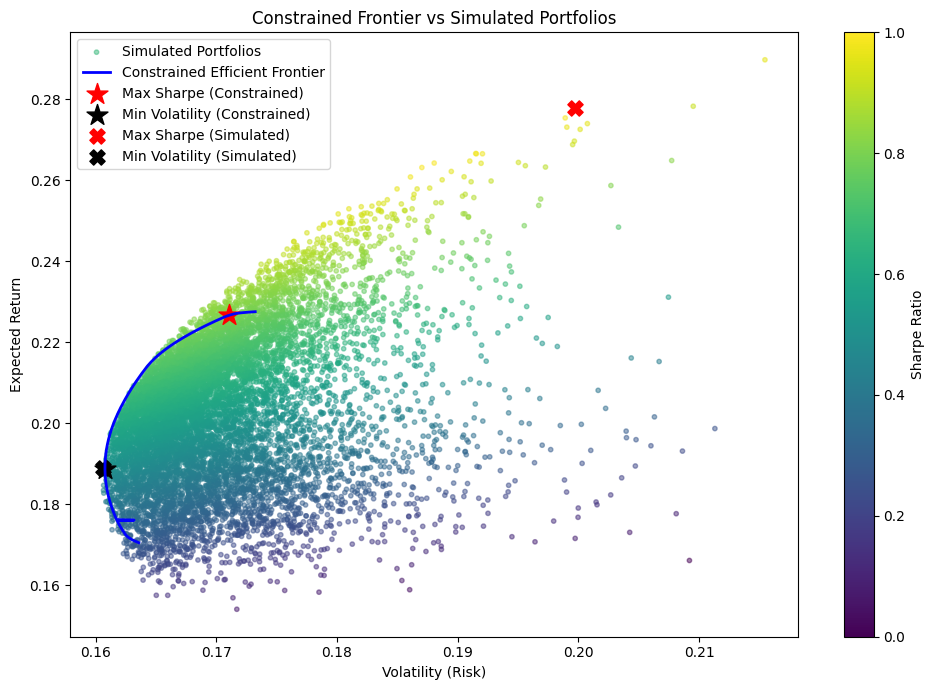

In [16]:
simulations_df = pd.read_csv("../Reports/portfolio_simulations.csv", index_col=0)

# --- Efficient Frontier (Constrained: Min Volatility for each return) ---
target_returns = np.linspace(simulations_df.index.min(), simulations_df.index.max(), 1000)
frontier_volatility = []
frontier_weights = []

for target in target_returns:
    constraints_frontier = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target}
    )
    result = minimize(
        portfolio_volatility,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_frontier
    )
    if result.success:
        frontier_volatility.append(result.fun)
        frontier_weights.append(result.x)
    else:
        frontier_volatility.append(np.nan)
        frontier_weights.append([np.nan]*len(expected_returns))

# --- Simulated Key Portfolios ---
sim_max_sharpe_idx = simulations_df['Sharp Ratios'].idxmax()
sim_min_vol_idx = simulations_df['volatility'].idxmin()

# --- Plot ---
plt.figure(figsize=(10, 7))

# Simulated portfolios
plt.scatter(simulations_df['volatility'], simulations_df.index,
            c=simulations_df['Sharp Ratios'], cmap='viridis', s=10, alpha=0.5, label="Simulated Portfolios")

# Constrained Efficient Frontier
plt.plot(frontier_volatility, target_returns, color='blue', lw=2, label="Constrained Efficient Frontier")

# Highlight constrained Max Sharpe
plt.scatter(opt_max_sharpe_data['Volatility'], opt_max_sharpe_data['Returns'],
            color='red', marker='*', s=250, label='Max Sharpe (Constrained)')

# Highlight constrained Min Volatility
plt.scatter(opt_min_vol_data['Volatility'], opt_min_vol_data['Returns'],
            color='black', marker='*', s=250, label='Min Volatility (Constrained)')

# Highlight simulated Max Sharpe
plt.scatter(simulations_df.loc[sim_max_sharpe_idx, 'volatility'], sim_max_sharpe_idx,
            color='red', marker='X', s=120, label='Max Sharpe (Simulated)')

# Highlight simulated Min Volatility
plt.scatter(simulations_df.loc[sim_min_vol_idx, 'volatility'], sim_min_vol_idx,
            color='black', marker='X', s=120, label='Min Volatility (Simulated)')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Constrained Frontier vs Simulated Portfolios")
plt.colorbar(label="Sharpe Ratio")
plt.legend()
plt.tight_layout()
plt.savefig("../Reports/Charts/Efficient_Frontiers_comparison.png")
plt.show()


## ✅ Interpretation of the Plot

In the plot:

- The **gradient-colored dots** represent 10,000 simulated portfolios constructed using real stock data.  
  - Each point shows a portfolio’s expected return vs. volatility, with color indicating its Sharpe Ratio.

- The **blue line** represents the constrained efficient frontier:  
  - These are portfolios that achieve minimum volatility for a given target return, under realistic investment constraints.

---

### 🔑 Key Insights

- **Constrained Max Sharpe Portfolio** (🔴):  
  - Shows a noticeable drop in returns compared to the unconstrained Max Sharpe portfolio.
  - This is partially offset by a reduction in volatility.
  - Reflects the trade-offs introduced by constraints such as maximum weight per stock or sector limits.

- **Min Volatility Portfolios** (⚫ ❌):  
  - For both constrained and simulated cases, these show very similar levels of return and risk.
  - Indicates that constraints have a smaller impact in ultra-conservative (low-risk) portfolios.

- **Sharpe Ratio Gap:**  
  - The large gap in Sharpe Ratios between constrained and unconstrained Max Sharpe portfolios may arise due to overconcentration in a single high-performing stock in the unconstrained case—a strategy that isn't viable or practical in real-world investing.


- **Frontier Comparison:**  
  - Notice that the constrained efficient frontier (blue line) lies **within** the cloud of simulated portfolios (the gradient).  
  - This demonstrates that unconstrained optimization can produce portfolios that are not feasible or realistic in practice, while the constrained frontier represents only those portfolios that satisfy real-world investment limits.

---

In [17]:
import yfinance as yf 

sector_mapping = {
    ticker : yf.Ticker(ticker).info.get('sector') for ticker in tickers
}


In [18]:
from collections import defaultdict

sector_indices = defaultdict(list)

# index-based grouping
for i, stock in enumerate(sector_mapping):
    sector = sector_mapping[stock]
    sector_indices[sector].append(i)
    
print(sector_indices)

defaultdict(<class 'list'>, {'Financial Services': [0, 1], 'Technology': [2, 4], 'Energy': [3]})


In [19]:
#this dict will later be brought as a input through the app
custom_sector_constraints = {
    'Technology': {'min': 0.05, 'max': 0.40},
    'Financial Services': {'min': 0.05, 'max': 0.40},
    'Energy': {'min': 0.05, 'max': 0.40}
}

sector_constraints = []

for sector, indices in sector_indices.items():
    if sector in custom_sector_constraints:
        min_limit = custom_sector_constraints[sector]['min']
        max_limit = custom_sector_constraints[sector]['max']

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, max_val=max_limit: max_val - np.sum(w[idx])
        })

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, min_val=min_limit: np.sum(w[idx]) - min_val
        })



all_constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
] + sector_constraints

all_constraints

[{'type': 'eq', 'fun': <function __main__.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], min_val=0.05)>}]

In [ ]:
opt_max_sharpe_sector = minimize(
    neg_sharpe_ratio,
    x0=init_guess,
    args=(expected_returns, cov_matrix, risk_free_rate),
    bounds=bounds,
    constraints=all_constraints,
    method='SLSQP',
    options={'ftol': 1e-9}
)
print(opt_max_sharpe_sector.x)
opt_max_sharpe_sector_data = {
    'Returns': portfolio_return(opt_max_sharpe_sector.x, expected_returns),
    'Volatility': portfolio_volatility(opt_max_sharpe_sector.x, cov_matrix),
    'Sharpe Ratio': (portfolio_return(opt_max_sharpe_sector.x, expected_returns) - risk_free_rate) / portfolio_volatility(opt_max_sharpe_sector.x, cov_matrix),
    'Weights': opt_max_sharpe_sector.x
}
opt_max_sharpe_sector_df = pd.DataFrame({
    "Stocks": tickers,
    "Weights": opt_max_sharpe_sector.x
})
opt_max_sharpe_sector_df.set_index("Stocks",inplace=True)
print(opt_max_sharpe_sector_data)
print(opt_max_sharpe_sector.x)
print(opt_max_sharpe_sector_df)

[0.1        0.3        0.3        0.22145771 0.07854229]
{'Returns': np.float64(0.2264809578935047), 'Volatility': np.float64(0.17099944469518943), 'Sharpe Ratio': np.float64(0.9735760147657845), 'Weights': array([0.1       , 0.3       , 0.3       , 0.22145771, 0.07854229])}
[0.1        0.3        0.3        0.22145771 0.07854229]
               Weights
Stocks                
HDFCBANK.NS   0.100000
ICICIBANK.NS  0.300000
INFY.NS       0.300000
RELIANCE.NS   0.221458
TCS.NS        0.078542


np.float64(-0.9735760147657845)

In [ ]:
for sector, indices in sector_indices.items():
    sector_weight = np.sum(opt_max_sharpe_sector.x[indices])
    sector_min = custom_sector_constraints[sector]['min']
    sector_max = custom_sector_constraints[sector]['max']

    print(f"{sector}: {sector_weight:.2%} (Min: {sector_min:.0%}, Max: {sector_max:.0%})")

    if sector_weight < sector_min or sector_weight > sector_max:
        print(f"⚠️ Constraint violation in {sector}: Outside [{sector_min:.0%}, {sector_max:.0%}] range.\n")



Financial Services: 40.00% (Min: 5%, Max: 40%)
⚠️ Constraint violation in Financial Services: Outside [5%, 40%] range.

Technology: 37.85% (Min: 5%, Max: 40%)
Energy: 22.15% (Min: 5%, Max: 40%)


In [ ]:
opt_min_vol_sector = minimize(
    portfolio_volatility,
    x0=init_guess,
    args=(cov_matrix,),
    bounds=bounds,
    constraints=all_constraints,
    method='SLSQP',
    options={'ftol': 1e-9}
)
print(opt_min_vol_sector.x)

opt_min_vol_sector_data = {
    'Returns': portfolio_return(opt_min_vol_sector.x, expected_returns),
    'Volatility': portfolio_volatility(opt_min_vol_sector.x, cov_matrix),
    'Sharpe Ratio': (portfolio_return(opt_min_vol_sector.x, expected_returns) - risk_free_rate) / portfolio_volatility(opt_min_vol_sector.x, cov_matrix),
    'Weights': opt_min_vol_sector.x
}

opt_min_vol_sector_df = pd.DataFrame({
    "Stocks": tickers,
    "Weights": opt_min_vol_sector_data['Weights']
})
opt_min_vol_sector_df.set_index("Stocks", inplace=True)

print(opt_min_vol_sector_df)

[0.24232834 0.15754614 0.092438   0.20768753 0.3       ]
               Weights
Stocks                
HDFCBANK.NS   0.242328
ICICIBANK.NS  0.157546
INFY.NS       0.092438
RELIANCE.NS   0.207688
TCS.NS        0.300000


In [ ]:
for sector, indices in sector_indices.items():
    sector_weight = np.sum(opt_min_vol_sector.x[indices])
    sector_min = custom_sector_constraints[sector]['min']
    sector_max = custom_sector_constraints[sector]['max']

    print(f"{sector}: {sector_weight:.2%} (Min: {sector_min:.0%}, Max: {sector_max:.0%})")

    if sector_weight < sector_min or sector_weight > sector_max:
        print(f"⚠️ Constraint violation in {sector}: Outside [{sector_min:.0%}, {sector_max:.0%}] range.\n")



Financial Services: 39.99% (Min: 5%, Max: 40%)
Technology: 39.24% (Min: 5%, Max: 40%)
Energy: 20.77% (Min: 5%, Max: 40%)


In [ ]:
sector_constrained_df = pd.DataFrame({
    "Stocks" : tickers,
    "Max Sharpe Weights":opt_max_sharpe_data['Weights'],
    'Min Volatility Weights': opt_min_vol_sector_data['Weights']
})

sector_constrained_df.set_index('Stocks',inplace=True)
sector_constrained_df.to_csv("../Reports/Sector_constrained_portfolio.csv")

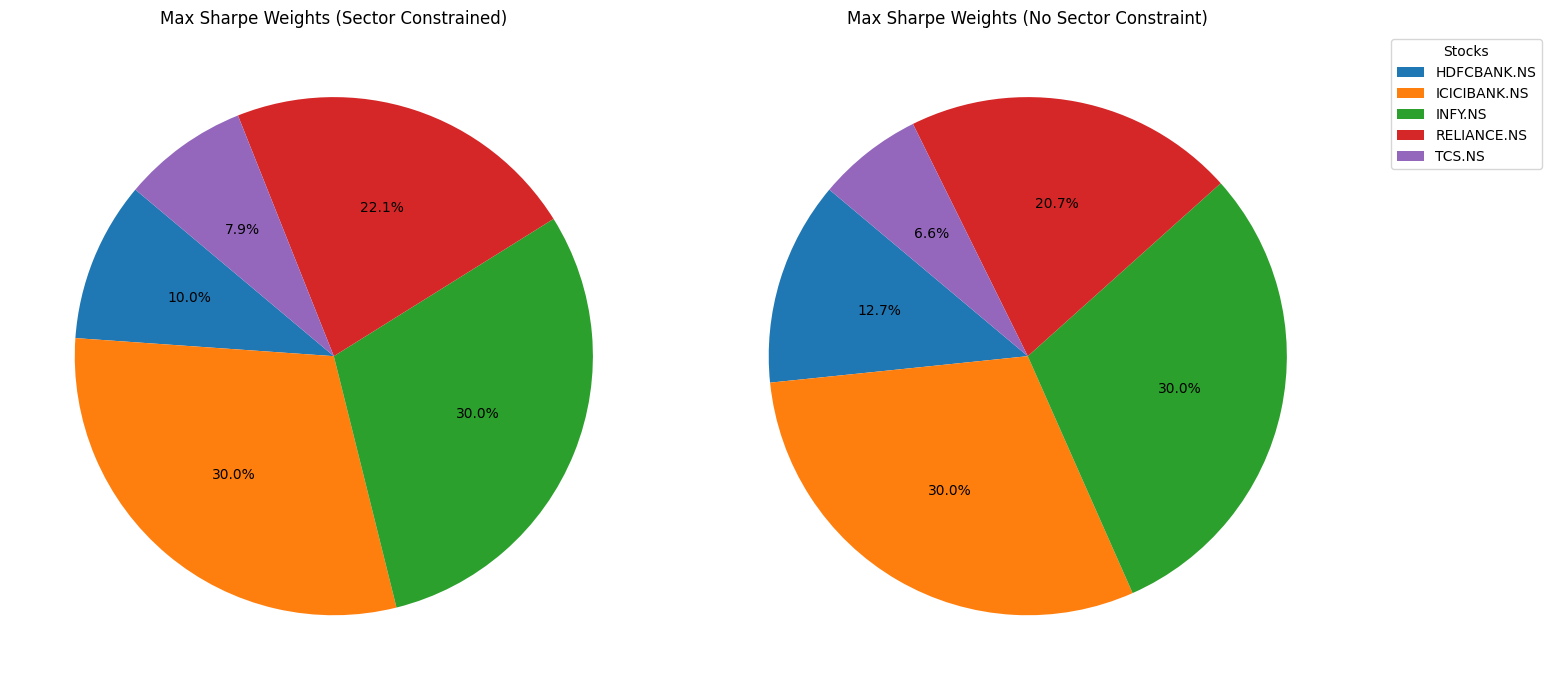

In [ ]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.pie(opt_max_sharpe_sector.x, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Max Sharpe Weights (Sector Constrained)")

plt.subplot(1, 2, 2)
plt.pie(opt_max_sharpe_data['Weights'], labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Max Sharpe Weights (No Sector Constraint)")
plt.legend(tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


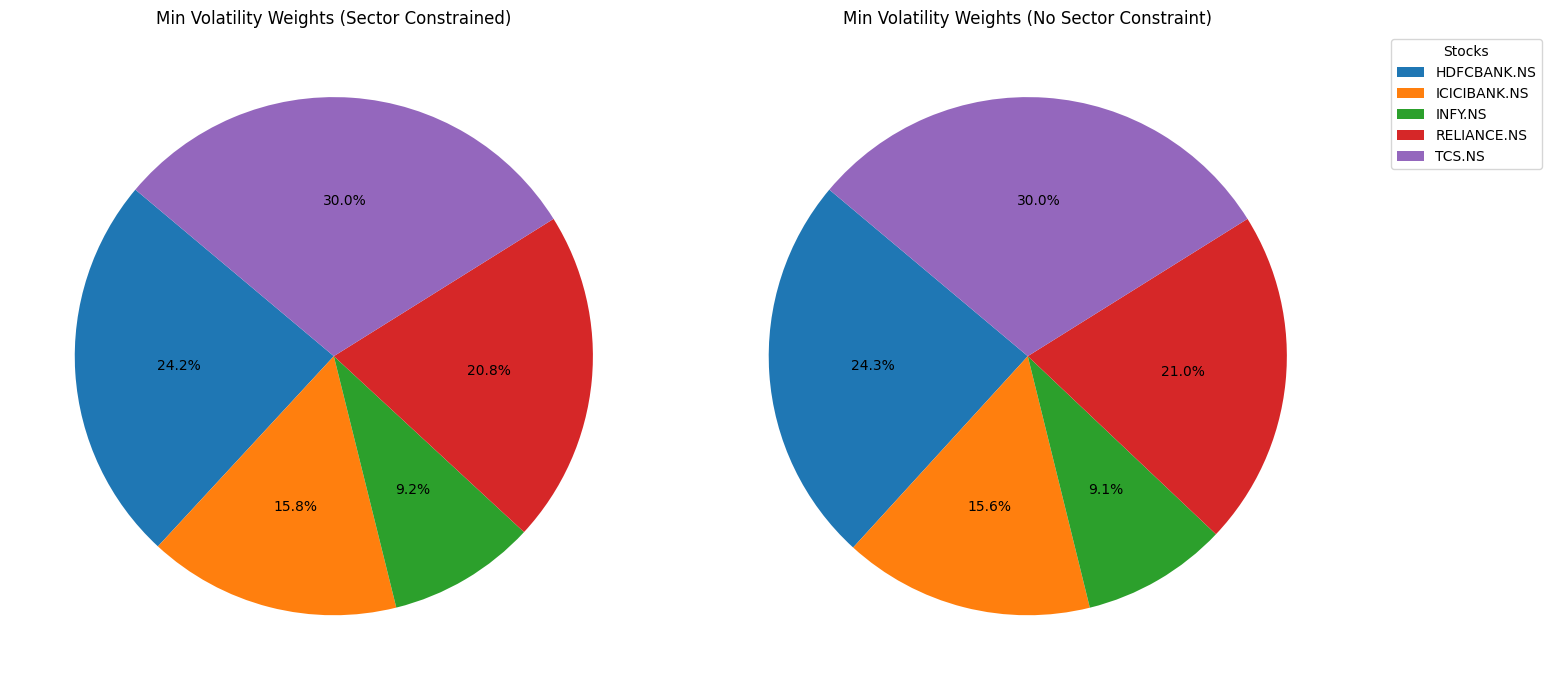

In [ ]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.pie(opt_min_vol_sector_df["Weights"].values, labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Min Volatility Weights (Sector Constrained)")

plt.subplot(1, 2, 2)
plt.pie(opt_min_vol_data['Weights'], labels=None, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title("Min Volatility Weights (No Sector Constraint)")
plt.legend(tickers, title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
c:\Users\Tanish\OneDrive\Documents\PortfolioOptimization\venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


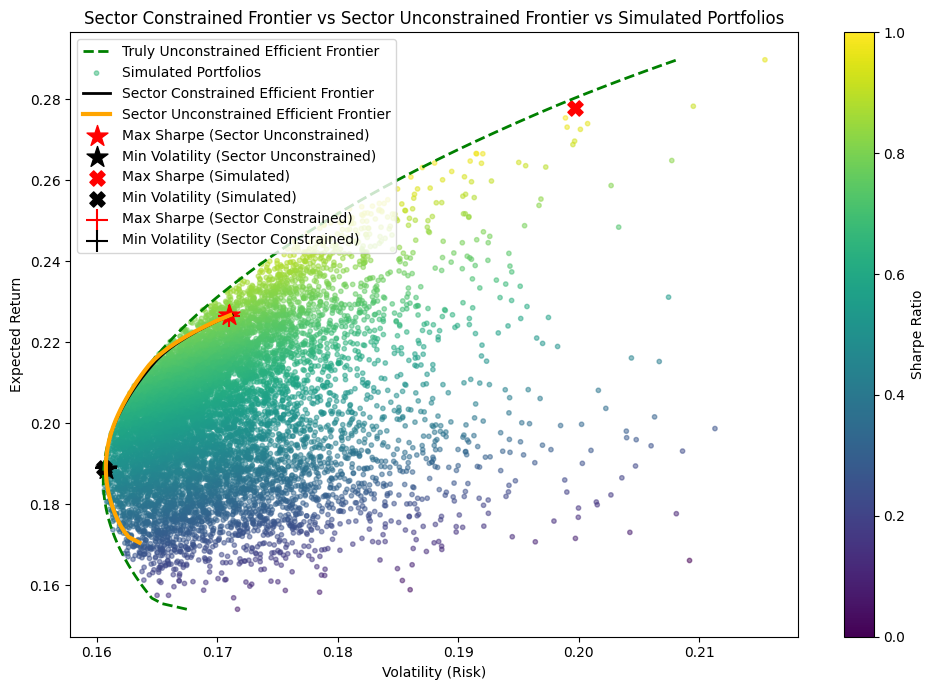

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ...existing code...

simulations_df = pd.read_csv("../Reports/portfolio_simulations.csv", index_col=0)
sim_max_sharpe_idx = simulations_df['Sharp Ratios'].idxmax()
sim_min_vol_idx = simulations_df['volatility'].idxmin()

# Assuming the index is expected returns
target_returns = np.linspace(simulations_df.index.min(), simulations_df.index.max(), 100)

sector_constrained_frontier_volatility = []
frontier_volatility_sector_unconstrained = []

for target in target_returns:
    sector_constraints_frontier = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target}
    ] + sector_constraints
    result_sector = minimize(
        portfolio_volatility,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=sector_constraints_frontier
    )
    if result_sector.success:
        sector_constrained_frontier_volatility.append(result_sector.fun)
    else:
        sector_constrained_frontier_volatility.append(np.nan)

    constraints_frontier = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target}
    ]
    result = minimize(
        portfolio_volatility,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_frontier
    )
    if result.success:
        frontier_volatility_sector_unconstrained.append(result.fun)
    else:
        frontier_volatility_sector_unconstrained.append(np.nan)

plt.figure(figsize=(10, 7))

unconstrained_bounds = [(0, 1)] * len(expected_returns)

# 2. Calculate truly unconstrained efficient frontier
frontier_volatility_truly_unconstrained = []

for target in target_returns:
    unconstrained_constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target}
    ]
    result_unconstrained = minimize(
        portfolio_volatility,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=unconstrained_bounds,
        constraints=unconstrained_constraints
    )
    if result_unconstrained.success:
        frontier_volatility_truly_unconstrained.append(result_unconstrained.fun)
    else:
        frontier_volatility_truly_unconstrained.append(np.nan)

plt.plot(frontier_volatility_truly_unconstrained, target_returns, color='green', lw=2, linestyle='--', label="Truly Unconstrained Efficient Frontier")

plt.scatter(simulations_df['volatility'], simulations_df.index,
            c=simulations_df['Sharp Ratios'], cmap='viridis', s=10, alpha=0.5, label="Simulated Portfolios")

plt.plot(sector_constrained_frontier_volatility, target_returns, color='black', lw=2, label="Sector Constrained Efficient Frontier")
plt.plot(frontier_volatility_sector_unconstrained, target_returns, color='orange', lw=3, label="Sector Unconstrained Efficient Frontier")

plt.scatter(opt_max_sharpe_data['Volatility'], opt_max_sharpe_data['Returns'],
            color='red', marker='*', s=250, label='Max Sharpe (Sector Unconstrained)')

plt.scatter(opt_min_vol_data['Volatility'], opt_min_vol_data['Returns'],
            color='black', marker='*', s=250, label='Min Volatility (Sector Unconstrained)')

plt.scatter(simulations_df.loc[sim_max_sharpe_idx, 'volatility'], sim_max_sharpe_idx,
            color='red', marker='X', s=120, label='Max Sharpe (Simulated)')

plt.scatter(simulations_df.loc[sim_min_vol_idx, 'volatility'], sim_min_vol_idx,
            color='black', marker='X', s=120, label='Min Volatility (Simulated)')

plt.scatter(opt_max_sharpe_sector_data['Volatility'], opt_max_sharpe_sector_data['Returns'],
            color='red', marker='+', s=250, label='Max Sharpe (Sector Constrained)')

plt.scatter(opt_min_vol_sector_data['Volatility'], opt_min_vol_sector_data['Returns'],
            color='black', marker='+', s=250, label='Min Volatility (Sector Constrained)')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Sector Constrained Frontier vs Sector Unconstrained Frontier vs Simulated Portfolios")
plt.colorbar(label="Sharpe Ratio")
plt.legend()
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("../Reports/Charts/efficient_frontier_comparison2.png", dpi=300, bbox_inches='tight')
plt.show()

{'__name__': '__main__',
 '__doc__': '\nNote: all executions are function-scoped as we do not assume the code below executes in an isolated kernel environment.\n',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().run_line_magic('pinfo', 'what')",
  'whi',
  "get_ipython().run_line_magic('who', '')",
  "get_ipython().run_line_magic('pinfo', 'who')",
  'import numpy as np\nimport pandas as pd\nfrom scipy.optimize import minimize\n\nexpected_returns = pd.read_csv("../Reports/expected_returns.csv",index_col= 0)\ntickers = np.array(expected_returns.index)\ncov_matrix = pd.read_csv("../Reports/cov_matrix.csv", index_col= 0)\nrisk_free_rate = 0.06\nprint(expected_returns,"\\n",cov_matrix)',
  "import numpy as np\nfrom scipy.optimize import minimize\n\n# Define functions\ndef portfolio_return(weights, expected_returns):\n    return np.dot(weights, expected